# Filling the database
In this notebook we fill the database with three tables, one table that holds the actual routes, and two tables which serve as helpers, listing up gyms and rock climbing holds.

So after running this our database will have these tables:

```plaintext 
           / holds      - Lists the types of rock climbing holds 
          // gyms       - Lists gyms, with details like address, zip code, name etc.
climbing --- walls      - Lists the actual rock climbing walls, listing ratings, difficulties, the gym...
          \\ wall_holds - Junction table, connects holds to walls listing the quantity 
           \ users      - Lists users with favorite hold, location gym ...
```


## What this file demonstrates 
- Understanding of SQL syntax, specifically;
    - Use of DDL for database management
    - Use of DML for data insertion and basic queries

- Use of pyodbc and interfacing with SQL from python, not only through workbench

- Understanding of schema structuring and handling data in a SQL way

## Let's see the schema in a a clearer way
The code for this is rather verbose and requires graphviz, plus uses the 

The Schema of our database after this file is run,


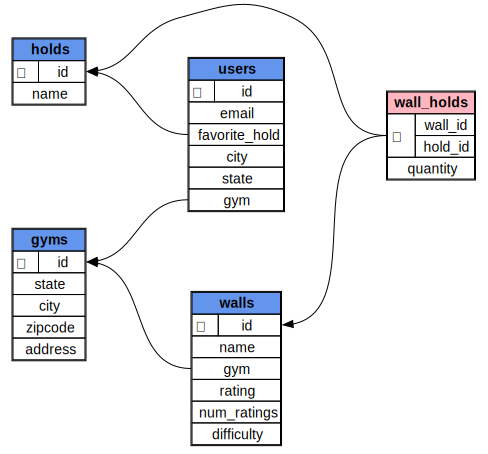

In [1]:
#######################################
# Visualize the schema in a graph

# Optional Cell, this cell is self contained and only produces the figure below, I do not recommend running it,
# if you want to run this cell you will need graphviz installed.

import graphviz

# Create the graph
schema = graphviz.Digraph(node_attr={'shape': 'record', 'fontname':'Helvetica,Arial,sans-serif'})

# I use HTML style nodes for this graph, and to indicate the primary key I use an extra column, for this reason all of the other rows are actually double width.
# the id is manually sorrounded by spaces for better positioning, PORTS are what the graphviz arrows will hook onto. This one creates the gyms table and the others the indicated tables.
schema.node('gyms',
            '<<TABLE BORDER="1" CELLBORDER="1" CELLSPACING="0">'
                '<TR><TD BGCOLOR="CornflowerBlue" PORT="gyms" COLSPAN="2"> <B>gyms</B> </TD></TR>'
                '<TR><TD PORT="key">🔑</TD><TD PORT="id">    id    </TD></TR>'
                '<TR><TD PORT="state" COLSPAN="2"> state </TD></TR>'
                '<TR><TD PORT="city" COLSPAN="2"> city </TD></TR>'
                '<TR><TD PORT="zipCode" COLSPAN="2"> zipcode </TD></TR>'
                '<TR><TD PORT="address" COLSPAN="2"> address </TD></TR>'
            '</TABLE>>',
            shape = 'none')

schema.node('holds',
            '<<TABLE BORDER="1" CELLBORDER="1" CELLSPACING="0">'
                '<TR><TD BGCOLOR="CornflowerBlue" PORT="holds" COLSPAN="2"> <B>holds</B> </TD></TR>'
                '<TR><TD PORT="key">🔑</TD><TD PORT="id">    id    </TD></TR>'
                '<TR><TD PORT="name" COLSPAN="2"> name </TD></TR>'
            '</TABLE>>',
            shape = 'none')

schema.node('walls',
            '<<TABLE BORDER="1" CELLBORDER="1" CELLSPACING="0">'
                '<TR><TD BGCOLOR="CornflowerBlue" PORT="walls" COLSPAN="2"> <B>walls</B> </TD></TR>'
                '<TR><TD PORT="key">🔑</TD><TD PORT="id">     id       </TD></TR>'
                '<TR><TD PORT="name" COLSPAN="2"> name </TD></TR>'
                '<TR><TD PORT="gym" COLSPAN="2"> gym </TD></TR>'
                '<TR><TD PORT="rating" COLSPAN="2"> rating </TD></TR>'
                '<TR><TD PORT="num_ratings" COLSPAN="2"> num_ratings </TD></TR>'
                '<TR><TD PORT="difficulty" COLSPAN="2"> difficulty </TD></TR>'
            '</TABLE>>',
            shape = 'none')
schema.edge('walls:gym','gyms:id')

schema.node('wall_holds',
            '<<TABLE BORDER="1" CELLBORDER="1" CELLSPACING="0">'
                '<TR><TD BGCOLOR="LightPink" PORT="wall_holds" COLSPAN="2"> <B>wall_holds </B> </TD></TR>'
                '<TR><TD PORT="key" ROWSPAN="2">🔑</TD> <TD PORT="wall_id"> wall_id </TD></TR>'
                '<TR PORT="hold_id"><TD> hold_id </TD></TR>'
                '<TR><TD PORT="quantity" COLSPAN = "2"> quantity </TD></TR>'
            '</TABLE>>',
            shape = 'none')
schema.edge('wall_holds:key:w','walls:id')
schema.edge('wall_holds:key:w','holds:id')

schema.node('users',
            '<<TABLE BORDER="1" CELLBORDER="1" CELLSPACING="0">'
                '<TR><TD BGCOLOR="CornflowerBlue" PORT="users" COLSPAN="2"> <B>users</B> </TD></TR>'
                '<TR><TD PORT="key">🔑</TD><TD PORT="id">      id        </TD></TR>'
                '<TR><TD PORT="email" COLSPAN="2"> email </TD></TR>'
                '<TR><TD PORT="favorite_hold" COLSPAN="2"> favorite_hold </TD></TR>'
                '<TR><TD PORT="city" COLSPAN="2"> city </TD></TR>'
                '<TR><TD PORT="state" COLSPAN="2"> state </TD></TR>'
                '<TR><TD PORT="gym" COLSPAN="2"> gym </TD></TR>'
            '</TABLE>>',
            shape = 'none')
schema.edge('users:favorite_hold','holds:id')
schema.edge('users:gym','gyms:id')
#schema.edge('users:state','gyms:state', color='crimson', style = 'dashed') # Potential joins, but not enforced by Foreign Key
#schema.edge('users:city','gyms:city', color='crimson', style = 'dashed') # ...

# The subgraphs and rankdir enforce a right to left alignment, foreign keys always flow leftwards. Also turn up the node and rank seperation a little bit to reduce how cramped the image is.
schema.attr(rankdir='RL')
schema.attr(nodesep='1', ranksep='1.2')

with schema.subgraph() as s:
    s.attr(rank = 'same')
    s.node('gyms')
    s.node('holds')

with schema.subgraph() as s:
    s.attr(rank = 'same')
    s.node('walls')
    s.node('users')

with schema.subgraph() as s:
    s.attr(rank = 'same')
    s.node('wall_holds')

# Finally present the schema
print("The Schema of our database after this file is run,")
display(schema) 

del(schema)

## Imports and presetup
We'll be using pyodbc to handle connection to the SQL server from python, pandas as a way to look at our tables in a python friendly way and then dotenv to load in our SQL database connection information.

In [2]:
import pyodbc

import pandas as pd 
# While pandas has a builtin read_sql and read_sql_query method, it is meant for use with SQLAlchemy and would throw warnings
# So we need to write our own quick helper func
def query_to_df(query, cursor):
    cursor.execute(query)
    cols = [desc[0] for desc in cursor.description]
    rows = cursor.fetchall()

    df = pd.DataFrame.from_records(data = rows, columns=cols)
    df.set_index(cols[0], inplace = True)
    return df

from dotenv import load_dotenv
import os

## Connect to the SQL database using credentials from .env, and reset the database for a clean slate
Setting up the pyodbc connection will depend on your database, here we've got a locally hosted mySQL DB.

In [3]:
load_dotenv()
USER = os.getenv("DB_USER")
PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")

if not 'cnxn' in locals():
    cnxn = pyodbc.connect("DRIVER={MySQL ODBC 9.3 Unicode Driver};"
                        "SERVER=localhost;" 
                        f"DATABASE={DB_NAME};"
                        f"USER={USER};"
                        f"PASSWORD={PASSWORD};"
                        "PORT=3306;"
                        "OPTION=3;")

cnxn.cursor().execute("DROP TABLE IF EXISTS users;")
cnxn.cursor().execute("DROP TABLE IF EXISTS wall_holds;")
cnxn.cursor().execute("DROP TABLE IF EXISTS walls;")
cnxn.cursor().execute("DROP TABLE IF EXISTS holds;")
cnxn.cursor().execute("DROP TABLE IF EXISTS gyms;")
cnxn.cursor()
cnxn.commit()

cursor = cnxn.cursor()

## Fill the holds table with preset hold names
We want to use a table listing the hold types, that we can potentially expand on in the future with more hold info. This also later helps us in a SQL way track which holds are on which walls.

In [4]:
# Create a table listing hold types by autogenerated ids
cursor.execute("""
                CREATE TABLE holds (
                    id SMALLINT AUTO_INCREMENT PRIMARY KEY, 
                    name VARCHAR(255) UNIQUE NOT NULL
               );
               """)
cnxn.commit()

# Fill it with some common hold names
cursor.execute("""
                INSERT INTO holds (name)
                VALUES 
                    ('Jug'),
                    ('Edge'),
                    ('Slab'),
                    ('Crimp'),
                    ('Pinch'),
                    ('Sloper'),
                    ('Undercling')
               """)
cnxn.commit()

# Run a selection to check that we've got what we expect in the table
temp_df = query_to_df("SELECT * FROM holds ORDER BY id", cursor)
temp_df.head()


,name
id,
1,Jug
2,Edge
3,Slab
4,Crimp
5,Pinch


## Create a randomized table of gyms
Here we'll set up a table of gyms for walls to assosciate to by Foreign Key, this will later let us select from walls that are in a gym, find out which gym a wall is in and more, which would all be expected as features.

Since we don't have real data to work with, but still want to fill out our tables enough to later perform interesting queries we'll be randomly generating data and storing it in tables. We have a pretty rudimentary model of a gym 
for demonstration, each gym will have an address, zip code, city and state, as well as a name and a unique id. In a real setting it would be potentially interesting to add other details as well, like opening hours or geo-location for 
better filtering by distance.

### Create a random list of gyms
We'll make a pretty limited list of gyms here based on the NY-PA-NJ tristate area. Each gym gets a name combination and is then randomly assigned other details. The zip code and city are sensibly selected according to the state, but the street address is random.

This cell here will just create the list and we'll hold onto that variable until next cell where we throw them into a table and take a peek.

In [5]:
import random

# Set up a list of states and associated cities to pull from 
states = ['Pennsylvania', 'New York', 'New Jersey']
cities = [['Philadelphia', 'Harrisburg', 'Pittsburgh'],['New York', 'Newark'],['Wilmington','Glassboro','Atlantic City']]
ZIP_Prefix = [[150,196],[10,14],[7,8]]

# Set up a list of randomized street name components
Street_init = ['Jane', 'Cherry', 'Dr Watson', 'Colonial', 'Center', 'Duck', 'Swan', 'New']
Street_terminal = [' Lane',' Street',' Boulevard',' Industrial Park', ' Drive']
Street_num = [0,350]

# Set up a list of randomized gym name components
Gym_prefix = ['Dave’s', 'Horton’s', 'Clear', 'Big', 'Climbathon']
Gym_terminal = [' Gym', ' Climb', ' Climbing Gym', ' Wall House']

# Generate every possible gym name from the above
names = [a + b for a in Gym_prefix for b in Gym_terminal]
gyms = []

# Associate each gym name with a random adress, city, state etc.
for name in names:
    state_idx = random.randint(0,len(states)-1) 
    state = states[state_idx]

    city = random.choice(cities[state_idx])

    zip_p = f"{random.randint(ZIP_Prefix[state_idx][0], ZIP_Prefix[state_idx][1]):03d}"
    zip_e = f"{random.randint(0,99):02d}"
    zip = zip_p + zip_e
    
    street = random.choice(Street_init) + random.choice(Street_terminal) + ' ' + str(random.randint(Street_num[0], Street_num[1]))
    
    gyms.append([name,state,city,zip,street])

random.shuffle(gyms) # Shuffle the gym list to keep all the Dave's from clumping 

del(zip)

### Create a table and fill it with the randomized gyms
Here we create a table for the gyms, just like the holds table this table is nothing fancy since the data is ideally structured for an RDMS.

At the end of the cell we constuct an insertion query that inserts all the gyms at once, and then perform a naive query to see the whole table which gives a really nice overview of it's structure.

In [6]:
# Create a table listing gyms that can hold all the data we wanted to add
cursor.execute("""
                CREATE TABLE gyms (
                    id SMALLINT AUTO_INCREMENT PRIMARY KEY, 
                    name VARCHAR(255) UNIQUE NOT NULL,
                    state VARCHAR(255) NOT NULL,
                    city VARCHAR(255) NOT NULL,
                    zipcode VARCHAR(255) NOT NULL,
                    address VARCHAR(255) NOT NULL
               );
               """)
cnxn.commit()

# Put together a dynamic insertion string that 
insert_root = """
INSERT INTO 
    gyms (name, state, city, zipcode, address)
VALUES
"""

insert = ''

for gym in gyms:
    insertion_str = ''
    for ele in gym:
        insertion_str = insertion_str + '\'' + ele + '\'' + ','

    insert = insert + '    (' + insertion_str[0:-1] + '),' + '\n'

insert = insert_root + insert[0:-2]+ ';'

# Let's show what the somewhat messily constructed insertion string looks like
print('Insertion: ', end='\n---------------------')
print(insert)

# And Run it
cnxn.execute(insert)
cnxn.commit()

# Then just like before let's check that the insertion did what we expected
print('\n\nResult:')
print('---------------------')
temp_df = query_to_df("SELECT * FROM gyms ORDER BY id", cursor)
temp_df.head()

Insertion: 
---------------------
INSERT INTO 
    gyms (name, state, city, zipcode, address)
VALUES
    ('Big Climb','Pennsylvania','Philadelphia','17633','Colonial Boulevard 339'),
    ('Clear Climb','Pennsylvania','Harrisburg','19113','New Drive 21'),
    ('Clear Wall House','New York','New York','01138','Jane Boulevard 116'),
    ('Climbathon Wall House','New York','Newark','01178','Cherry Boulevard 277'),
    ('Big Wall House','New York','New York','01447','Swan Drive 311'),
    ('Horton’s Climbing Gym','New York','New York','01126','Center Boulevard 141'),
    ('Clear Gym','New York','New York','01455','Swan Lane 162'),
    ('Clear Climbing Gym','New Jersey','Glassboro','00722','Dr Watson Lane 273'),
    ('Dave’s Climbing Gym','New Jersey','Wilmington','00716','Duck Drive 238'),
    ('Climbathon Climbing Gym','Pennsylvania','Philadelphia','19225','Swan Industrial Park 60'),
    ('Climbathon Gym','New Jersey','Glassboro','00747','Cherry Lane 185'),
    ('Horton’s Climb','New York'

,name,state,city,zipcode,address
id,,,,,
1,Big Climb,Pennsylvania,Philadelphia,17633,Colonial Boulevard 339
2,Clear Climb,Pennsylvania,Harrisburg,19113,New Drive 21
3,Clear Wall House,New York,New York,01138,Jane Boulevard 116
4,Climbathon Wall House,New York,Newark,01178,Cherry Boulevard 277
5,Big Wall House,New York,New York,01447,Swan Drive 311


### Set up the wall table, and a junction table to connect walls to holds

## Now we can finally make some climbing-walls and associate them with gyms
The wall table is a tiny bit more interesting, since here we need to impose some more requirements on our data, and we use a Foreign Key to reach out to the gym table, as well as creating a junction table for the holds on each wall, so let's look at these tables a bit more in detail.


#### Wall
A wall has plenty of the same types of columns as the gym, an id, a name, a rating, the number of ratings and a difficulty are all simple properties. There is one difference, before when we were looking at the gym we were assuming a reasonably small amount about the data, we trust our data source to be good, and since names and adresses can take many forms impose no real restrictions other than non-Nullness and uniqueness of gym names (which in real life is very likely not true). 

For the wall however we also have the columns rating and num_ratings, these are numbers, and numbers which we can strictly impose structure on, the rating should be between 0 and 5 and we mandate that as a check, likewise the number of ratings should be non-negative. Lastly we also have the gym column, which stores which gym the wall is actually in, since each wall that is associated to a gym should be associated to a gym that actually exists and is tracked we mark this as a Foreign Key, which imposes the requirement that the value stored in the gym column is present in the id column of the gyms, this lets us confidendently perform joins between these columns in the future.


#### Wall_Holds
The wall holds table is closely related to the wall table (and the holds table), and is even more complex in many ways. The wall_holds column is a so called junction table, this means that this table is acting as a many to many conection between holds and walls, and that that is it's primary purpose. In this case we want to know which holds are used on which walls, but each type of hold can obviously be used on multiple walls, and each wall will have many types of holds. Then by listing connections, we can create a graph like structure which can be queried for information on the walls, or, less likely in our case, the holds. 

The actual structure of this table is a table with two Foreign Keys, one to the walls and one to the holds, where each entry shows the existence of a hold on a wall. We also include the number of a hold for more information, but this is required to be aboce one. Additionaly since each wall to hold connection should only occur once (A hold type is or isn't on a wall) we use the combination of wall and hold type as the key.

An example of how we could use this is to ask "Is there a crimp on wall 5", which in SQL terms would become 

```plaintext
EXISTS(
    SELECT *
    FROM 
        wall_holds
    WHERE 
        hold_id = 4 
    AND 
        wall_id = 5
)
```

Though a more common application would be getting all of the walls with, or without, a hold to show to the user, which we will be doing when we use this DB.

#### What is the cell doing
In summary then, the cell below creates first a table for walls, then a junction table of holds to walls, and after that we demonstrate what an insertion command could look like into each of those tables, as well as how we can connect holds to walls and walls to gyms.

In [7]:
# Set up a new table that stores walls and links them to their respective gyms.
cursor.execute("""
                CREATE TABLE walls (
                    id SMALLINT PRIMARY KEY AUTO_INCREMENT,
                    name VARCHAR(255), 
                    gym SMALLINT,
                    rating FLOAT,
                    num_ratings INT NOT NULL,
                    difficulty VARCHAR(255),
                    CHECK(rating >= 0 AND rating <= 5),
                    CHECK(num_ratings >= 0),
                    FOREIGN KEY (gym) REFERENCES gyms(id)
                );
               """)
cnxn.commit()

# Set up a new table that stores the holds present by wall (Junction / Graph)
cursor.execute("""
                CREATE TABLE wall_holds (
                    wall_id SMALLINT,
                    hold_id SMALLINT,
                    quantity SMALLINT NOT NULL DEFAULT 1,
                    FOREIGN KEY (hold_id) REFERENCES holds(id),
                    FOREIGN KEY (wall_id) REFERENCES walls(id),
                    PRIMARY KEY (wall_id, hold_id),
                    CHECK(quantity >= 1)
                );
               """)
cnxn.commit()


# ########################################## 
# Now we can demonstrate how a manuaL wall insertion would look before we automate it in the next cell

# Create a standardish, named, wall with a couple of ratings, a fair rating and a standard difficulty, and
# a wall in gym two that's marked as a bit harder, rated poorly, and nameless.
cursor.execute("""
                INSERT INTO walls (gym, name, rating, num_ratings, difficulty)
                VALUES
                    (1, 'Brave Blue', 3.5, 27, 'V6'),
                    (2, Null, 2.5, 1, 'V8')
               """)

# Associate some holds to the walls 
# Very vaguely wall 1 has a mix of holds, and wall two is a balancy wall with tons of slab and some crimp
cursor.execute("""
                INSERT INTO wall_holds (wall_id, hold_id, quantity)
                VALUES
                    (1, 1, 4),
                    (1, 2, 2),
                    (1, 7, 2),
                    (1, 3, 1),
                    (2, 4, 3),
                    (2, 3, 8)
               """)

# And display the result of our queries, but joined up so that we can read out the holds in a clear way.
get_walls = """
        SELECT 
               walls.id AS wall_id,
               gyms.name AS gym_name,
               walls.name AS name,
               walls.rating,
               walls.difficulty
        FROM walls
        INNER JOIN gyms ON walls.gym = gyms.id
        ORDER BY walls.rating DESC, gyms.name, walls.id
        """

print("Walls after creation of wall table:")
df = query_to_df(get_walls, cursor)
display(df.head())

# Or if we want to know how the holds are distributed
get_holds = """
        SELECT  
                holds.name AS hold,
                CONCAT(
                    COALESCE(walls.name, 'Not Named'),
                    ' : ',
                    walls.id
                ) AS 'wall name : id',
                wall_holds.quantity AS count
        FROM 
            wall_holds
        INNER JOIN 
            holds ON holds.id = wall_holds.hold_id
        INNER JOIN
            walls ON walls.id = wall_holds.wall_id
        ORDER BY 
            walls.rating DESC, wall_id, hold
        """

print("\n\nPresence of holds on walls")
df = query_to_df(get_holds, cursor)
display(df)

Walls after creation of wall table:


,gym_name,name,rating,difficulty
wall_id,,,,
1,Big Climb,Brave Blue,3.5,V6
2,Clear Climb,None,2.5,V8




Presence of holds on walls


,wall name : id,count
hold,,
Edge,Brave Blue : 1,2
Jug,Brave Blue : 1,4
Slab,Brave Blue : 1,1
Undercling,Brave Blue : 1,2
Crimp,Not Named : 2,3
Slab,Not Named : 2,8


### Randomly Generate a bunch of walls
Here we using the same tables as above automatically fill them by randomly generating walls. Then we again take a look at the tables, this time with more entries in them.

In [8]:
# First we make some lists for the randomization to pull from
import urllib.request
words = urllib.request.urlopen("https://www.mit.edu/~ecprice/wordlist.10000").read().decode().splitlines() # https://stackoverflow.com/questions/18834636/random-word-generator-python
difficulties = ['B'] + [str(num) for num in range(0,13)]
holds = query_to_df("Select * From holds", cursor).index.tolist()

# Define a wall generation function that we can run for as many walls as we want
def generate_wall():
    score = random.random()*5
    num_ratings = random.randint(0,1000)
    
    difficulty = 'V' + str(random.choice(difficulties))

    nameL = random.sample(words, random.randint(0,2))
    name = '-'.join([str(a) for a in nameL])
    if len(name) == 0: name = None

    hold = random.sample(holds, random.randint(1,7))
    counts = [random.randint(1,9) for h in hold]

    gymid = random.randint(1,len(gyms))

    return ([gymid, name, score, num_ratings, difficulty], [hold, counts])

# Set An Average of 6 walls per gym and roll the wals
num_walls = len(gyms)*6 
walls = [generate_wall() for i in range(num_walls)]

# Loop over each of the walls we created in the list and make a query to insert it, as well as adding the new holds
for wall in walls:
    wall_info = wall[0]
    insert_str = f"""INSERT INTO walls (gym, name, rating, num_ratings, difficulty)
                      VALUES
                         ({wall_info[0]},'{wall_info[1]}',{wall_info[2]},{wall_info[3]},'{wall_info[4]}')"""
    cursor.execute(insert_str)

    cursor.execute("SELECT LAST_INSERT_ID()") # Need this to grab the id to associate the holds to since we're autogenning ids.
    id = cursor.fetchone()[0] #type: ignore

    # To add the holds we transform the paired list of hold ids and counts to a list of tuples before fstringing them into a request
    holds_info = wall[1]
    for hold_info in zip(holds_info[0], holds_info[1]): #type: ignore
            insert_str = f"""
                INSERT INTO wall_holds (wall_id, hold_id, quantity)
                VALUES
                    ({id},{hold_info[0]},{hold_info[1]})
               """
            cursor.execute(insert_str)

             
# Check the output
print("Walls after filling of wall table:")
df = query_to_df(get_walls, cursor)
display(df)

print("\n\nPresence of holds on walls")
df = query_to_df(get_holds, cursor)
display(df)

Walls after filling of wall table:


,gym_name,name,rating,difficulty
wall_id,,,,
102,Big Climbing Gym,None,4.957980,VB
6,Climbathon Gym,stopped,4.932160,V1
54,Horton’s Climb,remarkable,4.900850,V1
34,Clear Gym,rental,4.881640,V4
104,Horton’s Climb,None,4.842380,V10
...,...,...,...,...
66,Big Gym,infected,0.197442,V12
81,Climbathon Climb,mailing,0.153294,V6
109,Dave’s Wall House,marshall-horses,0.055321,V8




Presence of holds on walls


,wall name : id,count
hold,,
Crimp,None : 102,6
Jug,None : 102,7
Pinch,None : 102,1
Slab,None : 102,2
Sloper,None : 102,8
...,...,...
Edge,artistic : 92,8
Pinch,artistic : 92,1
Slab,artistic : 92,4


## Now we add three dummy users manually that we can test from later
Since we'll be working more on how we can dynamically filter, select and concatenate data in the next file we also want a table of users, with preferences and locations that we can use as test cases. The user table is really nothing new and is similar to the walls table.

### Create the user table
A realatively simple table, Foreign Keys to gyms and holds, and stores a unique email used as a username, but also uses an internal id in case the email changes. Keeps track of the users listed location, favorite gym and favorite hold.

In [9]:
# Create a user table
cursor.execute("""
CREATE TABLE users (
    id SMALLINT AUTO_INCREMENT PRIMARY KEY,
    email VARCHAR(255) UNIQUE NOT NULL,
    favorite_hold SMALLINT,
    city VARCHAR(255),
    state VARCHAR(255),
    gym SMALLINT,
    FOREIGN KEY (gym) REFERENCES gyms(id),
    FOREIGN KEY (favorite_hold) REFERENCES holds(id)
)
""")
cursor.commit()

### Fill the user table
Here we do a final demonstration of manual insertion, we create a couple users to demo users with similar tastes and good data as well as users with missing information

In [10]:
# Let's start with a couple John and Jane who live in Pennsylvania and have filled in a favorite gym, Jane likes slab and John likes edge
# And let's add their son Jack Doe who's moved to New Jersey but has the same favorite gym as his parents
cursor.execute("""
INSERT INTO 
    users (email, favorite_hold, city, state, gym)
VALUES
    ("JaneDoe@goodData.com", 3, "Harrisburg", "Pennsylvania", 3),
    ("JohnDoe@goodData.com", 2, "Harrisburg", "Pennsylvania", 3),
    ("JackDoe@goodData.com", 6, "Cherry Hill", "New Jersey", 3)
""")

# Now lets create three users who are a bit less commited, one each who skipped filling out a favorite hold, city and state or gym
cursor.execute("""
INSERT INTO
    users (email, favorite_hold, city, state)
VALUES
    ("NoahJims@skipMail.org", 3, "Newark", "New York")
""")

cursor.execute("""
INSERT INTO
    users (email, city, state, gym)
VALUES
    ("HoldenLacksson@skipMail.org", "Newark", "New York", 10)
""")

cursor.execute("""
INSERT INTO
    users (email, favorite_hold, gym)
VALUES
    ("BenAway@skipMail.org", 4, 2)
""");


### Show the user table (Joined with Gym names and Hold names for clarity)
We can see here that the insertion went well with another broad selection, note the left joins here which we use since we have a couple of None cases that would be dropped by an inner join.

In [11]:
# Put together and run query for users info.
get_users = """
SELECT 
    users.id AS uid,
    users.email AS email,
    gyms.name AS gym,
    holds.name AS 'favorite hold',
    CONCAT(users.city,'-', users.state) AS location
FROM users
LEFT JOIN gyms ON users.gym = gyms.id
LEFT JOIN holds ON users.favorite_hold = holds.id
"""
df = query_to_df(get_users, cursor)
display(df)


,email,gym,favorite hold,location
uid,,,,
1,JaneDoe@goodData.com,Clear Wall House,Slab,Harrisburg-Pennsylvania
2,JohnDoe@goodData.com,Clear Wall House,Edge,Harrisburg-Pennsylvania
3,JackDoe@goodData.com,Clear Wall House,Sloper,Cherry Hill-New Jersey
4,NoahJims@skipMail.org,None,Slab,Newark-New York
5,HoldenLacksson@skipMail.org,Climbathon Climbing Gym,None,Newark-New York
6,BenAway@skipMail.org,Clear Climb,Crimp,None


## With that our DB is filled so the next step is to set up an interface and some queries to run in another file

So here we just close up our connection to the DB. In a real software product you'd want a handler for your connection(s), and potentially to use or cursors more locally or for less queries but for our demo this is more than sufficient.

In [12]:
# Close cursor
cursor.close()
cnxn.close()

del(cursor, cnxn)